In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

# Load the diabetes dataset
data = load_breast_cancer()

# Convert the dataset to a DataFrame
data_df = pd.DataFrame(data=data.data,
                           columns=data.feature_names)

# Add target variable to the DataFrame
data_df['target'] = data.target

print(data_df.head(2))

# Print the shape of the feature matrix and target vector
print("Shape of Sklearn Breast Cancer Data:", data_df.shape)

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33            184.6      2019.0   
1                 0.05667  ...          23.41            158.8      1956.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   

   worst symmetry  worst fractal dimension  target  
0          0.

In [2]:
#总体缺失值检查
print("Missing values in all columns:\n", data_df.isnull().sum().sum())

Missing values in all columns:
 0


In [3]:
#数值特征缩放
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_df[data.feature_names] = scaler.fit_transform(data_df[data.feature_names])
print("First two rows after scaling:\n", data_df.head(2))

First two rows after scaling:
    mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0     1.097064     -2.073335        1.269934   0.984375         1.568466   
1     1.829821     -0.353632        1.685955   1.908708        -0.826962   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0          3.283515        2.652874             2.532475       2.217515   
1         -0.487072       -0.023846             0.548144       0.001392   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                2.255747  ...      -1.359293         2.303601    2.001237   
1               -0.868652  ...      -0.369203         1.535126    1.890489   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0          1.307686           2.616665         2.109526              2.296076   
1         -0.375612          -0.430444        -0.146749              1.087084   

   worst symmetry  worst fractal di

In [4]:
# 特征选择
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
rf = RandomForestClassifier(random_state=42)
rf.fit(data_df.drop(columns=['target']), data_df['target'])
selector = SelectFromModel(rf, prefit=True)
selected_features = data_df.drop(columns=['target']).columns[selector.get_support()]
print('Selected features:', selected_features)
data_df = data_df[selected_features.tolist() + ['target']]
print("Shape after feature selection:", data_df.shape)

Selected features: Index(['mean radius', 'mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'worst radius', 'worst perimeter', 'worst area',
       'worst concavity', 'worst concave points'],
      dtype='object')
Shape after feature selection: (569, 11)


In [5]:
train_test_split_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(data_df.drop(columns=['target']),
                                                    data_df['target'],
                                                    test_size=train_test_split_ratio,
                                                    random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (455, 10)
X_test shape: (114, 10)
y_train shape: (455,)
y_test shape: (114,)


## 算法一：支持向量机（软间隔最大化）

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 创建支持向量机模型（软间隔最大化，默认C=1.0）
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# 训练模型
svm_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = svm_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")

SVM Accuracy: 0.9825


In [7]:
import numpy as np

# 将标签转换为-1和1（SVM标准）
y_train_svm = np.where(y_train == 0, -1, 1)

# 计算决策函数值
decision_values = svm_model.decision_function(X_train)

# 计算松弛变量 ξ_i = max(0, 1 - y_i * f(x_i))
slack_variables = np.maximum(0, 1 - y_train_svm * decision_values)

# 检查松弛变量
non_zero_slacks = np.sum(slack_variables > 0)
total_slack = np.sum(slack_variables)

print(f"训练样本中具有非零松弛变量的数量: {non_zero_slacks}")
print(f"总松弛变量和: {total_slack:.4f}")

训练样本中具有非零松弛变量的数量: 65
总松弛变量和: 55.7334


### 接下来对C进行超参优化
### 优化结果表明C=1时已达最优

In [8]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {'C': [0.1, 1, 10, 100, 1000]}

# 创建GridSearchCV对象
grid_search = GridSearchCV(SVC(kernel='linear', random_state=42), param_grid, cv=5, scoring='accuracy')

# 拟合网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳交叉验证分数
print("最佳参数:", grid_search.best_params_)
print("最佳交叉验证分数:", grid_search.best_score_)

# 输出全部结果
import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
print("\n所有网格搜索结果:")
print(results[['param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# 使用最佳模型进行预测
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"\n最佳SVM在测试集上的准确率: {accuracy_best:.4f}")

最佳参数: {'C': 1}
最佳交叉验证分数: 0.9494505494505494

所有网格搜索结果:
   param_C  mean_test_score  std_test_score  rank_test_score
0      0.1         0.942857        0.014579                5
1      1.0         0.949451        0.013187                1
2     10.0         0.949451        0.028317                1
3    100.0         0.949451        0.039069                1
4   1000.0         0.947253        0.032151                4

最佳SVM在测试集上的准确率: 0.9825


## 算法二：KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# 创建KNN模型（默认k=5）
knn_model = KNeighborsClassifier(n_neighbors=5)

# 训练模型
knn_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_knn = knn_model.predict(X_test)

# 计算准确率
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN准确率 (k=5): {accuracy_knn:.4f}")

# KNN超参优化：选择最佳k值
param_grid_knn = {'n_neighbors': list(range(1, 21))}  # k从1到20

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')

grid_search_knn.fit(X_train, y_train)

print("最佳参数:", grid_search_knn.best_params_)
print("最佳交叉验证分数:", grid_search_knn.best_score_)

# 输出全部结果
results_knn = pd.DataFrame(grid_search_knn.cv_results_)
print("\n所有KNN网格搜索结果:")
print(results_knn[['param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(5))  # 显示前5个

# 使用最佳模型进行预测
best_knn = grid_search_knn.best_estimator_
y_pred_best_knn = best_knn.predict(X_test)
accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
print(f"\n最佳KNN在测试集上的准确率: {accuracy_best_knn:.4f}")
print("- 在本实验中，最佳k值为", grid_search_knn.best_params_['n_neighbors'], "，测试准确率为", f"{accuracy_best_knn:.4f}", "。")

KNN准确率 (k=5): 0.9737
最佳参数: {'n_neighbors': 4}
最佳交叉验证分数: 0.945054945054945

所有KNN网格搜索结果:
   param_n_neighbors  mean_test_score  std_test_score  rank_test_score
0                  1         0.931868        0.010767                3
1                  2         0.918681        0.011207               18
2                  3         0.938462        0.019160                2
3                  4         0.945055        0.012038                1
4                  5         0.931868        0.018906                3

最佳KNN在测试集上的准确率: 0.9737
- 在本实验中，最佳k值为 4 ，测试准确率为 0.9737 。
最佳参数: {'n_neighbors': 4}
最佳交叉验证分数: 0.945054945054945

所有KNN网格搜索结果:
   param_n_neighbors  mean_test_score  std_test_score  rank_test_score
0                  1         0.931868        0.010767                3
1                  2         0.918681        0.011207               18
2                  3         0.938462        0.019160                2
3                  4         0.945055        0.012038                1
4      

### 测试不同的KNN距离度量

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 重新运行网格搜索以获取最佳k值（确保一致性）
param_grid_knn = {'n_neighbors': list(range(1, 21))}
grid_search_knn_temp = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn_temp.fit(X_train, y_train)
best_k = grid_search_knn_temp.best_params_['n_neighbors']
print(f"最佳k值: {best_k}")

# 定义不同的距离度量
metrics = ['euclidean', 'manhattan', 'cosine']

# 存储结果
results = {}

for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[metric] = acc
    print(f"{metric} 距离的准确率: {acc:.4f}")

print("\n距离度量比较:")
for metric, acc in results.items():
    print(f"{metric}: {acc:.4f}")

最佳k值: 4
euclidean 距离的准确率: 0.9737
manhattan 距离的准确率: 0.9737
cosine 距离的准确率: 0.9825

距离度量比较:
euclidean: 0.9737
manhattan: 0.9737
cosine: 0.9825


### 基线算法比较

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

# 基线算法：Dummy Classifier（多数类分类器）
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
print(f"基线算法（Dummy Classifier）准确率: {accuracy_dummy:.4f}")

# KNN算法作为对比
knn = KNeighborsClassifier(n_neighbors=4, metric='cosine')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN准确率: {accuracy_knn:.4f}")

# SVM准确率（从之前的结果）
print(f"SVM准确率: {accuracy_best:.4f}")

# 比较
print("\n算法比较:")
print(f"Dummy: {accuracy_dummy:.4f}")
print(f"KNN: {accuracy_knn:.4f}")
print(f"SVM: {accuracy_best:.4f}")

基线算法（Dummy Classifier）准确率: 0.6228
KNN准确率: 0.9825
SVM准确率: 0.9825

算法比较:
Dummy: 0.6228
KNN: 0.9825
SVM: 0.9825


## 深化评价指标
#### (更详细地评估SVM与KNN在数据集上的效果表现)

In [12]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# 深化评价指标：计算F1-score等
print("深化评价指标（使用最佳模型）:")

# SVM
y_pred_svm = best_model.predict(X_test)
print("\nSVM分类报告:")
print(classification_report(y_test, y_pred_svm, target_names=['Benign', 'Malignant']))
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
print(f"SVM F1-score: {f1_svm:.4f}, Precision: {precision_svm:.4f}, Recall: {recall_svm:.4f}")

# KNN
knn_cosine = KNeighborsClassifier(n_neighbors=4, metric='cosine')  # 使用最佳k=4和余弦距离
knn_cosine.fit(X_train, y_train)
y_pred_knn_best = knn_cosine.predict(X_test)
print("\nKNN分类报告:")
print(classification_report(y_test, y_pred_knn_best, target_names=['Benign', 'Malignant']))
f1_knn = f1_score(y_test, y_pred_knn_best, average='weighted')
precision_knn = precision_score(y_test, y_pred_knn_best, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn_best, average='weighted')
print(f"KNN F1-score: {f1_knn:.4f}, Precision: {precision_knn:.4f}, Recall: {recall_knn:.4f}")

# Dummy
y_pred_dummy = dummy.predict(X_test)
f1_dummy = f1_score(y_test, y_pred_dummy, average='weighted')
print(f"\nDummy F1-score: {f1_dummy:.4f}")

print("\n算法比较 (F1-score):")
print(f"Dummy: {f1_dummy:.4f}")
print(f"KNN: {f1_knn:.4f}")
print(f"SVM: {f1_svm:.4f}")

深化评价指标（使用最佳模型）:

SVM分类报告:
              precision    recall  f1-score   support

      Benign       0.98      0.98      0.98        43
   Malignant       0.99      0.99      0.99        71

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

SVM F1-score: 0.9825, Precision: 0.9825, Recall: 0.9825

KNN分类报告:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        43
   Malignant       1.00      0.97      0.99        71

    accuracy                           0.98       114
   macro avg       0.98      0.99      0.98       114
weighted avg       0.98      0.98      0.98       114

KNN F1-score: 0.9825, Precision: 0.9832, Recall: 0.9825

Dummy F1-score: 0.4780

算法比较 (F1-score):
Dummy: 0.4780
KNN: 0.9825
SVM: 0.9825


## 算法性能对比：ROC 和 PR 曲线

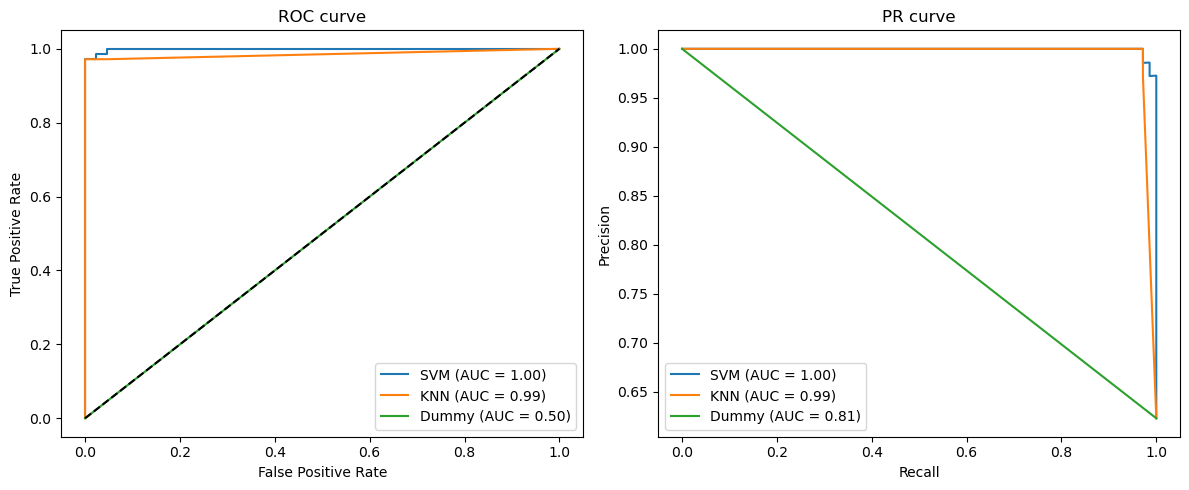

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 获取预测概率
y_prob_svm = best_model.decision_function(X_test)  # SVM决策函数
y_prob_knn = knn_cosine.predict_proba(X_test)[:, 1]  # KNN概率
y_prob_dummy = dummy.predict_proba(X_test)[:, 1]  # Dummy概率

# ROC 曲线
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_prob_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

# PR 曲线
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_prob_svm)
pr_auc_svm = auc(recall_svm, precision_svm)

precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_prob_knn)
pr_auc_knn = auc(recall_knn, precision_knn)

precision_dummy, recall_dummy, _ = precision_recall_curve(y_test, y_prob_dummy)
pr_auc_dummy = auc(recall_dummy, precision_dummy)

# 绘制 ROC 曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_dummy, tpr_dummy, label=f'Dummy (AUC = {roc_auc_dummy:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()

# 绘制 PR 曲线
plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label=f'SVM (AUC = {pr_auc_svm:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AUC = {pr_auc_knn:.2f})')
plt.plot(recall_dummy, precision_dummy, label=f'Dummy (AUC = {pr_auc_dummy:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend()

plt.tight_layout()
plt.show()

## 多组合消融实验：尝试不同特征组合

In [14]:
# 多组合消融实验
combinations = {
    '去掉所有mean特征': [col for col in X_train.columns if 'mean' in col],
    '去掉面积相关特征': [col for col in X_train.columns if 'area' in col],
    '去掉凹点相关特征': [col for col in X_train.columns if 'concave points' in col],
    '去掉worst特征': [col for col in X_train.columns if 'worst' in col]
}

original_svm_acc = accuracy_best
original_knn_acc = 0.9825

results_multi = {}

for name, features_to_remove in combinations.items():
    print(f"\n消融组合: {name}")
    print(f"去掉的特征: {features_to_remove}")

    X_train_drop = X_train.drop(columns=features_to_remove)
    X_test_drop = X_test.drop(columns=features_to_remove)

    print(f"剩余特征数量: {X_train_drop.shape[1]}")

    # 训练SVM
    svm_drop = SVC(kernel='linear', C=1.0, random_state=42)
    svm_drop.fit(X_train_drop, y_train)
    y_pred_svm_drop = svm_drop.predict(X_test_drop)
    acc_svm_drop = accuracy_score(y_test, y_pred_svm_drop)

    # 训练KNN
    knn_drop = KNeighborsClassifier(n_neighbors=4, metric='cosine')
    knn_drop.fit(X_train_drop, y_train)
    y_pred_knn_drop = knn_drop.predict(X_test_drop)
    acc_knn_drop = accuracy_score(y_test, y_pred_knn_drop)

    drop_svm = original_svm_acc - acc_svm_drop
    drop_knn = original_knn_acc - acc_knn_drop

    results_multi[name] = {
        'svm_acc': acc_svm_drop,
        'knn_acc': acc_knn_drop,
        'svm_drop': drop_svm,
        'knn_drop': drop_knn
    }

    print(f"SVM准确率: {acc_svm_drop:.4f} (下降: {drop_svm:.4f})")
    print(f"KNN准确率: {acc_knn_drop:.4f} (下降: {drop_knn:.4f})")

# 总结
print("\n=== 消融实验总结 ===")
for name, res in results_multi.items():
    print(f"{name}: SVM下降 {res['svm_drop']:.4f}, KNN下降 {res['knn_drop']:.4f}")

# 给出理由
print("\n=== 消融理由 ===")
print("1. 去掉所有mean特征: mean特征代表平均值，可能提供基础统计信息，去掉测试模型对全局趋势的依赖。")
print("2. 去掉面积相关特征: 面积特征高度相关于半径和周长，去掉测试冗余性。")
print("3. 去掉凹点相关特征: 凹点特征捕捉肿瘤形状复杂性，去掉评估形状信息的重要性。")
print("4. 去掉worst特征: worst特征表示最坏值，敏感于异常，去掉测试边界条件的贡献。")


消融组合: 去掉所有mean特征
去掉的特征: ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points']
剩余特征数量: 5
SVM准确率: 0.9561 (下降: 0.0263)
KNN准确率: 0.9825 (下降: 0.0000)

消融组合: 去掉面积相关特征
去掉的特征: ['mean area', 'worst area']
剩余特征数量: 8
SVM准确率: 0.9825 (下降: 0.0000)
KNN准确率: 0.9825 (下降: 0.0000)

消融组合: 去掉凹点相关特征
去掉的特征: ['mean concave points', 'worst concave points']
剩余特征数量: 8
SVM准确率: 0.9912 (下降: -0.0088)
KNN准确率: 0.9825 (下降: 0.0000)

消融组合: 去掉worst特征
去掉的特征: ['worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']
剩余特征数量: 5
SVM准确率: 0.9035 (下降: 0.0789)
KNN准确率: 0.9298 (下降: 0.0527)

=== 消融实验总结 ===
去掉所有mean特征: SVM下降 0.0263, KNN下降 0.0000
去掉面积相关特征: SVM下降 0.0000, KNN下降 0.0000
去掉凹点相关特征: SVM下降 -0.0088, KNN下降 0.0000
去掉worst特征: SVM下降 0.0789, KNN下降 0.0527

=== 消融理由 ===
1. 去掉所有mean特征: mean特征代表平均值，可能提供基础统计信息，去掉测试模型对全局趋势的依赖。
2. 去掉面积相关特征: 面积特征高度相关于半径和周长，去掉测试冗余性。
3. 去掉凹点相关特征: 凹点特征捕捉肿瘤形状复杂性，去掉评估形状信息的重要性。
4. 去掉worst特征: worst特征表示最坏值，敏感于异常，去掉测试边界条件的贡献。


## 极端消融实验：只保留一个特征

In [15]:
# 极端消融实验：只保留一个特征
features = list(X_train.columns)
results_single = {}

for feature in features:
    # 只保留该特征
    X_train_single = X_train[[feature]]
    X_test_single = X_test[[feature]]

    # 训练SVM
    svm_single = SVC(kernel='linear', C=1.0, random_state=42)
    svm_single.fit(X_train_single, y_train)
    y_pred_svm_single = svm_single.predict(X_test_single)
    acc_svm_single = accuracy_score(y_test, y_pred_svm_single)

    # 训练KNN
    knn_single = KNeighborsClassifier(n_neighbors=4, metric='cosine')
    knn_single.fit(X_train_single, y_train)
    y_pred_knn_single = knn_single.predict(X_test_single)
    acc_knn_single = accuracy_score(y_test, y_pred_knn_single)

    results_single[feature] = {
        'svm_acc': acc_svm_single,
        'knn_acc': acc_knn_single
    }

# 打印结果，按SVM准确率排序
print("极端消融实验结果（只保留一个特征）:")
print("特征\t\t      SVM准确率\t\tKNN准确率")
for feature in sorted(results_single.keys(), key=lambda x: results_single[x]['svm_acc'], reverse=True):
    res = results_single[feature]
    print(f"{feature:<20}  {res['svm_acc']:.4f}\t\t{res['knn_acc']:.4f}")

# 最优特征
best_svm_feature = max(results_single.keys(), key=lambda x: results_single[x]['svm_acc'])
best_knn_feature = max(results_single.keys(), key=lambda x: results_single[x]['knn_acc'])
print(f"\nSVM最优单特征: {best_svm_feature} (准确率: {results_single[best_svm_feature]['svm_acc']:.4f})")
print(f"KNN最优单特征: {best_knn_feature} (准确率: {results_single[best_knn_feature]['knn_acc']:.4f})")

极端消融实验结果（只保留一个特征）:
特征		      SVM准确率		KNN准确率
worst perimeter       0.9561		0.9737
worst radius          0.9474		0.9561
worst area            0.9474		0.9474
mean area             0.9386		0.8947
mean radius           0.9298		0.8772
mean perimeter        0.9298		0.8772
worst concave points  0.9211		0.9123
mean concavity        0.8860		0.9211
mean concave points   0.8860		0.9035
worst concavity       0.8596		0.8509

SVM最优单特征: worst perimeter (准确率: 0.9561)
KNN最优单特征: worst perimeter (准确率: 0.9737)


## 模型失败案例分析

### 决策值和预测概率解释
- **决策值 (Decision Function)**：SVM模型输出的决策函数值，表示样本到分类超平面的距离。正值表示预测为正类（恶性肿瘤），负值表示负类（良性肿瘤）。值越接近0，表示样本越接近决策边界，模型置信度越低。
- **预测概率 (Prediction Probability)**：KNN模型输出的概率值，表示样本属于正类的概率（0到1之间）。值越接近1，表示模型越确信样本为正类；越接近0，越确信为负类。

In [16]:
# 模型失败案例分析：找出2-3个错误预测的样本
import numpy as np

# 使用最佳SVM模型
y_pred_svm = best_model.predict(X_test)
y_prob_svm = best_model.decision_function(X_test)  # 决策函数值，作为概率近似

# 使用最佳KNN模型
knn_best = KNeighborsClassifier(n_neighbors=4, metric='cosine')
knn_best.fit(X_train, y_train)
y_pred_knn = knn_best.predict(X_test)
y_prob_knn = knn_best.predict_proba(X_test)[:, 1]  # 预测为阳性的概率

# 找出SVM错误预测的样本
svm_errors = np.where(y_pred_svm != y_test)[0]
knn_errors = np.where(y_pred_knn != y_test)[0]

print("=== SVM 失败案例 ===")
for i in range(min(3, len(svm_errors))):
    idx = svm_errors[i]
    true_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    pred_label = y_pred_svm[idx]
    prob = y_prob_svm[idx]
    features = X_test.iloc[idx].to_dict() if hasattr(X_test, 'iloc') else X_test[idx]
    formatted_features = {k: round(v, 2) for k, v in features.items()}
    print(f"样本编号: {idx}, 真实标签: {true_label}, 预测标签: {pred_label}, 决策值: {prob:.4f}")
    print(f"  特征值: {formatted_features}")
    print("  出错原因: 决策值接近0，模型对边界样本分类困难。\n")

print("=== KNN 失败案例 ===")
for i in range(min(3, len(knn_errors))):
    idx = knn_errors[i]
    true_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    pred_label = y_pred_knn[idx]
    prob = y_prob_knn[idx]
    features = X_test.iloc[idx].to_dict() if hasattr(X_test, 'iloc') else X_test[idx]
    formatted_features = {k: round(v, 2) for k, v in features.items()}
    print(f"样本编号: {idx}, 真实标签: {true_label}, 预测标签: {pred_label}, 预测概率: {prob:.4f}")
    print(f"  特征值: {formatted_features}")
    print("  出错原因: 邻域内多数样本标签与真实标签不一致，导致误分类。\n")

=== SVM 失败案例 ===
样本编号: 8, 真实标签: 1, 预测标签: 0, 决策值: -0.0928
  特征值: {'mean radius': -0.22, 'mean perimeter': -0.23, 'mean area': -0.38, 'mean concavity': 0.35, 'mean concave points': 0.54, 'worst radius': -0.15, 'worst perimeter': -0.32, 'worst area': -0.47, 'worst concavity': 1.02, 'worst concave points': 0.86}
  出错原因: 决策值接近0，模型对边界样本分类困难。

样本编号: 82, 真实标签: 0, 预测标签: 1, 决策值: 0.4784
  特征值: {'mean radius': 0.1, 'mean perimeter': 0.09, 'mean area': -0.02, 'mean concavity': 0.4, 'mean concave points': 0.01, 'worst radius': -0.01, 'worst perimeter': 0.03, 'worst area': -0.13, 'worst concavity': 0.3, 'worst concave points': 0.12}
  出错原因: 决策值接近0，模型对边界样本分类困难。

=== KNN 失败案例 ===
样本编号: 8, 真实标签: 1, 预测标签: 0, 预测概率: 0.0000
  特征值: {'mean radius': -0.22, 'mean perimeter': -0.23, 'mean area': -0.38, 'mean concavity': 0.35, 'mean concave points': 0.54, 'worst radius': -0.15, 'worst perimeter': -0.32, 'worst area': -0.47, 'worst concavity': 1.02, 'worst concave points': 0.86}
  出错原因: 邻域内多数样本标签与真实标签不一致，导致误分类。

样

In [17]:
# 分析失败案例中哪些特征导致误分类
import numpy as np

# SVM特征重要性（系数）
svm_coef = best_model.coef_[0]  # 线性SVM的系数
feature_names = X_train.columns

print("=== SVM 特征重要性 (系数) ===")
for name, coef in zip(feature_names, svm_coef):
    print(f"{name}: {coef:.4f}")

print("\n=== SVM 失败案例特征贡献分析 ===")
for i in range(min(3, len(svm_errors))):
    idx = svm_errors[i]
    features = X_test.iloc[idx].values
    contributions = features * svm_coef
    sorted_contrib = sorted(zip(feature_names, contributions), key=lambda x: abs(x[1]), reverse=True)
    print(f"\n样本 {idx} (真实: {y_test.iloc[idx]}, 预测: {y_pred_svm[idx]}, 决策值: {y_prob_svm[idx]:.4f})")
    print("主要贡献特征 (绝对值排序):")
    for name, contrib in sorted_contrib[:5]:  # 前5个
        print(f"  {name}: {contrib:.4f}")

print("\n=== KNN 失败案例特征分析 ===")
# 对于KNN，分析特征值是否异常（与训练均值比较）
train_means = X_train.mean()
train_stds = X_train.std()

for i in range(min(3, len(knn_errors))):
    idx = knn_errors[i]
    features = X_test.iloc[idx]
    z_scores = (features - train_means) / train_stds
    sorted_z = sorted(zip(feature_names, z_scores), key=lambda x: abs(x[1]), reverse=True)
    print(f"\n样本 {idx} (真实: {y_test.iloc[idx]}, 预测: {y_pred_knn[idx]}, 概率: {y_prob_knn[idx]:.4f})")
    print("最异常特征 (Z-score绝对值排序):")
    for name, z in sorted_z[:5]:  # 前5个
        print(f"  {name}: Z={z:.2f} (值: {features[name]:.2f})")

=== SVM 特征重要性 (系数) ===
mean radius: 0.8014
mean perimeter: 0.8825
mean area: -0.0414
mean concavity: 0.0985
mean concave points: -0.8464
worst radius: -1.7088
worst perimeter: -0.6388
worst area: -2.0204
worst concavity: -0.3235
worst concave points: -0.6960

=== SVM 失败案例特征贡献分析 ===

样本 8 (真实: 1, 预测: 0, 决策值: -0.0928)
主要贡献特征 (绝对值排序):
  worst area: 0.9436
  worst concave points: -0.5956
  mean concave points: -0.4574
  worst concavity: -0.3316
  worst radius: 0.2616

样本 82 (真实: 0, 预测: 1, 决策值: 0.4784)
主要贡献特征 (绝对值排序):
  worst area: 0.2546
  worst concavity: -0.0973
  worst concave points: -0.0837
  mean perimeter: 0.0829
  mean radius: 0.0803

=== KNN 失败案例特征分析 ===

样本 8 (真实: 1, 预测: 0, 概率: 0.0000)
最异常特征 (Z-score绝对值排序):
  worst concavity: Z=1.01 (值: 1.02)
  worst concave points: Z=0.87 (值: 0.86)
  mean concave points: Z=0.57 (值: 0.54)
  worst area: Z=-0.46 (值: -0.47)
  mean area: Z=-0.38 (值: -0.38)

样本 108 (真实: 1, 预测: 0, 概率: 0.0000)
最异常特征 (Z-score绝对值排序):
  worst concave points: Z=0.70 (值: 0.6

## 所用库及版本号

In [18]:
import numpy as np
import pandas as pd
import matplotlib
import sklearn

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)

numpy: 1.26.4
pandas: 2.2.3
matplotlib: 3.8.4
scikit-learn: 1.5.1
